In [1]:
import pandas as pd
import os
import numpy as np
import requests
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import time
import json
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import openmeteo_requests
import requests_cache
from retry_requests import retry
import hsfs
from pathlib import Path
from dotenv import load_dotenv
import hopsworks
import sys

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from format_data import format_weather_data, format_price_data, merge_data
from get_electricity_prices import get_data
from get_weather_data import get_historical_weather, get_weather_forecast

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from format_data import format_weather_data, format_price_data, process_weather_data
from get_electricity_prices import get_data
from get_weather_data import get_historical_weather, get_weather_forecast
from entsoe_data import fetch_historical_data, ensure_valid_series

In [3]:
load_dotenv()
hopsworks_api = os.getenv("HOPSWORKS_API_KEY")

os.environ["HOPSWORKS_API_KEY"] = hopsworks_api

project = hopsworks.login()

print(f"Connected to project: {project.name}")

2025-01-06 22:05:04,059 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-06 22:05:04,071 INFO: Initializing external client
2025-01-06 22:05:04,072 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-06 22:05:05,382 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164446
Connected to project: oskaralf


In [4]:
def get_feature_group_as_dataframe(project_name, feature_group_name, version=1):
    fs = project.get_feature_store()
    feature_group = fs.get_feature_group(name=feature_group_name, version=version)
    df = feature_group.read()
    return df

In [5]:
fs = project.get_feature_store()

In [6]:
#price_df = get_feature_group_as_dataframe(project.name, "electricity_price_data")
weather_df = get_feature_group_as_dataframe(project.name, "weather_data_3")
entsoe_df = get_feature_group_as_dataframe(project.name, "entsoe_data_3")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 


In [7]:
weather_fg = fs.get_feature_group(
    name='weather_data_3',
    version=1,
)

entsoe_fg = fs.get_feature_group(
    name='entsoe_data_3',
    version=1,
)

In [8]:
entsoe_columns = [
     'prices', 'imported_energy', 'total_load', 'total_generation_se',
     'prices_lag', 'imported_energy_lag', 'total_load_lag',
     'total_generation_se_lag', 'future_price'
 ]

weather_columns = [
    'date', 'temperature_2m', 'wind_speed_100m',
    'temperature_2m_lag', 'wind_speed_100m_lag']

selected_features = entsoe_fg.select(entsoe_columns).join(weather_fg.select(weather_columns), on=['date'], join_type='inner')
#selected_features = entsoe_query.join(weather_query, on=['date'])



# Show the first 10 rows of the feature view to verify
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.11s) 


,prices,imported_energy,total_load,total_generation_se,prices_lag,imported_energy_lag,total_load_lag,total_generation_se_lag,future_price,date,temperature_2m,wind_speed_100m,temperature_2m_lag,wind_speed_100m_lag
0,37.00,-2125.0,20363.0,3313.0,55.26,-2133.0,20351.0,2917.0,38.76,2022-11-01 03:00:00+00:00,8.565000,17.283749,8.615000,16.454008
1,77.99,-1354.0,25407.0,3946.0,59.95,-1533.0,23883.0,3924.0,84.40,2022-11-01 07:00:00+00:00,8.264999,16.516901,8.214999,14.869351
2,91.30,-1995.0,26023.0,3295.0,72.17,-1895.0,25661.0,3853.0,97.84,2022-11-02 15:00:00+00:00,9.365000,22.682856,10.615000,21.841648
3,40.21,-1993.0,20767.0,3413.0,38.95,-2084.0,20719.0,3206.0,42.47,2022-11-03 03:00:00+00:00,6.115000,21.933426,6.065000,19.966211
4,76.00,-2009.0,24412.0,3956.0,50.00,-2199.0,22447.0,3951.0,87.20,2022-11-03 06:00:00+00:00,7.465000,15.021105,7.215000,17.782686
5,100.02,-2688.0,25923.0,2546.0,68.35,-2452.0,24461.0,2348.0,103.30,2022-11-04 07:00:00+00:00,8.115000,29.142216,7.715000,28.017622
6,240.55,-2254.0,26481.0,4567.0,122.21,-2013.0,26961.0,4137.0,213.76,2022-11-04 18:00:00+00:00,8.065000,32.839027,8.014999,32.583481
7,129.04,-2620.0,21896.0,2320.0,53.02,-2707.0,21278.0,2272.0,139.39,2022-11-05 07:00:00+00:00,8.415000,29.964457,8.415000,29.964457
8,114.45,-2005.0,24069.0,2731.0,133.83,-2155.0,23740.0,2701.0,96.36,2022-11-05 11:00:00+00:00,7.365000,29.379175,8.415000,32.856781
9,88.72,-2291.0,23828.0,2436.0,96.36,-1977.0,23999.0,2595.0,109.63,2022-11-05 13:00:00+00:00,7.415000,28.555965,7.465000,29.304090


In [9]:
feature_view = fs.get_or_create_feature_view(
    name='electricity_price_fv_3',
    description="weather + entose features with electricity prices as the target",
    version=1,
    labels=['future_price'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1164446/fs/1155149/fv/electricity_price_fv_3/version/1


In [10]:
from random import seed


X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size = 0.2, seed=42
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.12s) 
2025-01-06 22:05:39,501 WARNING: VersionWarning: Incremented version to `1`.



In [11]:
# Get the maximum dates in X_train and X_test
max_date_train = X_train['date'].max()
max_date_test = X_test['date'].max()

# Check which dataset contains the maximum date
if max_date_train > max_date_test:
    max_id = X_train['date'].idxmax()
    X_train = X_train.drop(max_id)
else:
    max_id = X_test['date'].idxmax()
    X_test = X_test.drop(max_id)

training_features = X_train.drop(columns=['date'])
test_features = X_test.drop(columns=['date'])

y_train = y_train.dropna()
y_test = y_test.dropna()

In [12]:
#  check length of all dataframes
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

print(len(training_features))
print(len(test_features))

print(training_features.columns)

14807
3703
14807
3703
14807
3703
Index(['prices', 'imported_energy', 'total_load', 'total_generation_se',
       'prices_lag', 'imported_energy_lag', 'total_load_lag',
       'total_generation_se_lag', 'temperature_2m', 'wind_speed_100m',
       'temperature_2m_lag', 'wind_speed_100m_lag'],
      dtype='object')


In [13]:
os.makedirs('model', exist_ok=True)

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,  
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=1.0,
    #  reg_alpha = 1
    reg_lambda=1.0  # Moderate L2 regularization
)
xgb_regressor.fit(training_features, y_train)

# Predictions on training and test sets
y_train_pred = xgb_regressor.predict(training_features)
y_test_pred = xgb_regressor.predict(test_features)

# Calculate MSE and R² for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate MSE and R² for test set
test_mse = mean_squared_error(y_test.iloc[:, 0], y_test_pred)
test_r2 = r2_score(y_test.iloc[:, 0], y_test_pred)

# Print results
print("Training Set Results:")
print(f"  MSE: {train_mse:.4f}")
print(f"  R²: {train_r2:.4f}")

print("\nTest Set Results:")
print(f"  MSE: {test_mse:.4f}")
print(f"  R²: {test_r2:.4f}")



Training Set Results:
  MSE: 49.2746
  R²: 0.9898

Test Set Results:
  MSE: 227.5492
  R²: 0.9579


In [22]:
# correlation matrix
#import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,20))
# cor = X_train.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()


In [15]:
df = y_test
df['predicted_price'] = y_test_pred

In [16]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.tail(5)

,future_price,predicted_price,date
12762,17.00,14.655585,2024-12-31 14:00:00+00:00
5764,25.98,24.158104,2024-12-31 17:00:00+00:00
10555,2.16,0.714535,2024-12-31 23:00:00+00:00
8151,34.69,35.132660,2025-01-06 09:00:00+00:00
16244,24.86,22.882574,2025-01-06 19:00:00+00:00


2025-01-06 22:06:09,454 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



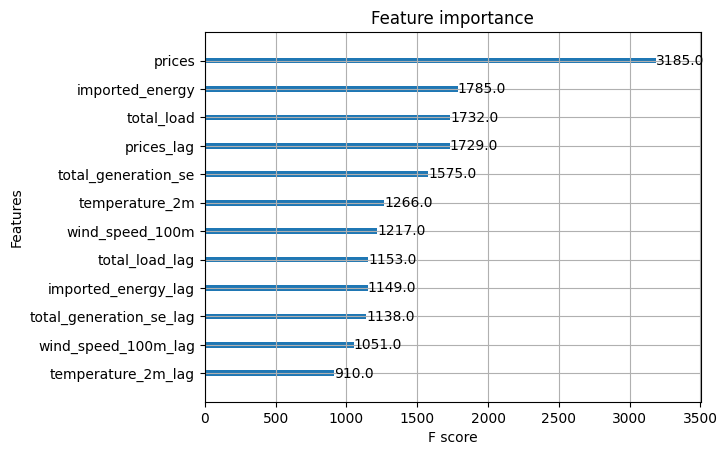

In [17]:
#featureimportanceanalysis
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgb_regressor)
pyplot.show()


In [18]:
model_dir = "SE3_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [19]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(training_features)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [20]:
xgb_regressor.save_model(model_dir + "/model_se3.json")

In [21]:
res_dict = { 
        "MSE": str(test_mse),
        "R squared": str(test_r2),
    }

In [22]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

se3_model = mr.python.create_model(
    name="electricity_xgboost_model_se3", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Electricity prices predictor for SE3",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
se3_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/1957039 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/176 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1126 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1164446/models/electricity_xgboost_model_se3/1


Model(name: 'electricity_xgboost_model_se3', version: 1)